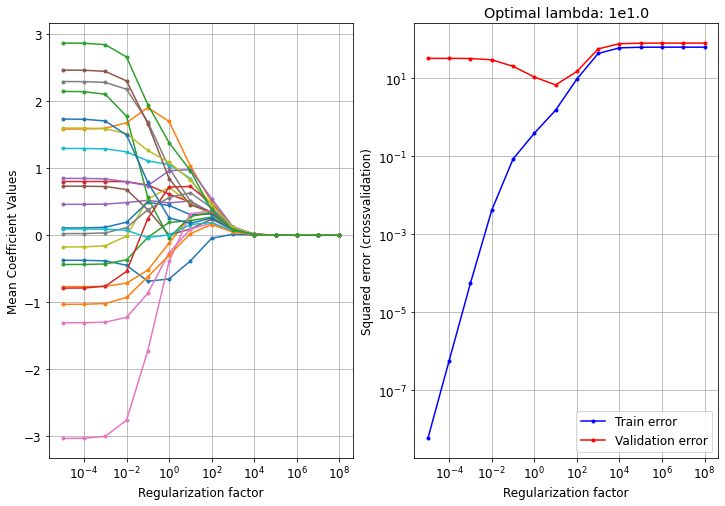

Linear regression without feature selection:
- Training error: 2.2207254897312914e-25
- Test error:     257.46892165429097
- R^2 train:     1.0
- R^2 test:     -3.451044214987123

Regularized linear regression:
- Training error: 1.5475686817544771
- Test error:     5.775481189219005
- R^2 train:     0.9776617006312921
- R^2 test:     0.9001552421516823

Weights in last fold:
         Offset           77.08
     biacromial           -0.43
 pelvic.breadth            0.24
 bitrochanteric             0.2
    chest.depth            0.48
     chest.diam            0.51
     elbow.diam            0.07
     wrist.diam            0.09
      knee.diam            0.54
     ankle.diam            0.49
 shoulder.girth            0.89
    chest.girth             0.3
    waist.girth             1.1
    navel.girth            0.26
      hip.girth            0.74
    thigh.girth            1.01
    bicep.girth            0.47
  forearm.girth            0.29
     knee.girth            0.64
     calf.girt

In [8]:
# exercise 8.1.1

from matplotlib.pylab import (figure, semilogx, loglog, xlabel, ylabel, legend, 
                           title, subplot, show, grid)
import numpy as np
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import rlr_validate

mat_data = loadmat('02450_toolbox/Data/body.mat')
X = mat_data['X']
y = mat_data['y'].squeeze()
attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attributeNames = [u'Offset']+attributeNames
M = M+1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(K, shuffle=True)
#CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.,range(-5,9))

# Initialize variables
#T = len(lambdas)
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))

k=0
for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10    
    
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :] 
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:,k] = np.linalg.solve(XtX,Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = np.square(y_train-X_train @ w_noreg[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test[k] = np.square(y_test-X_test @ w_noreg[:,k]).sum(axis=0)/y_test.shape[0]
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    #m = lm.LinearRegression().fit(X_train, y_train)
    #Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    #Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K-1:
        figure(k, figsize=(12,8))
        subplot(1,2,1)
        semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
        xlabel('Regularization factor')
        ylabel('Mean Coefficient Values')
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner 
        # plot, since there are many attributes
        #legend(attributeNames[1:], loc='best')
        
        subplot(1,2,2)
        title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
        loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        xlabel('Regularization factor')
        ylabel('Squared error (crossvalidation)')
        legend(['Train error','Validation error'])
        grid()
    
    # To inspect the used indices, use these print statements
    #print('Cross validation fold {0}/{1}:'.format(k+1,K))
    #print('Train indices: {0}'.format(train_index))
    #print('Test indices: {0}\n'.format(test_index))

    k+=1

show()
# Display results
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

print('Weights in last fold:')
for m in range(M):
    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,-1],2)))

print('Ran Exercise 8.1.1')

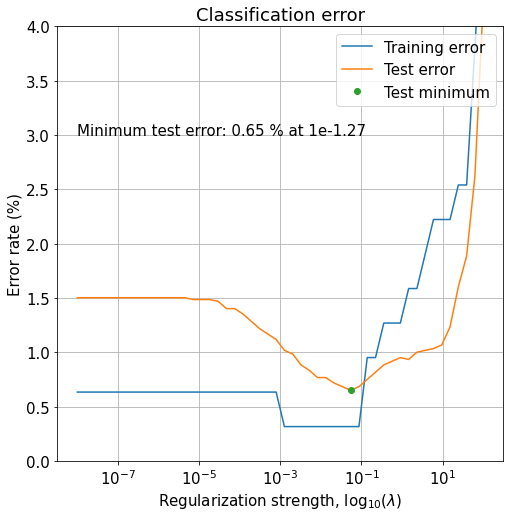

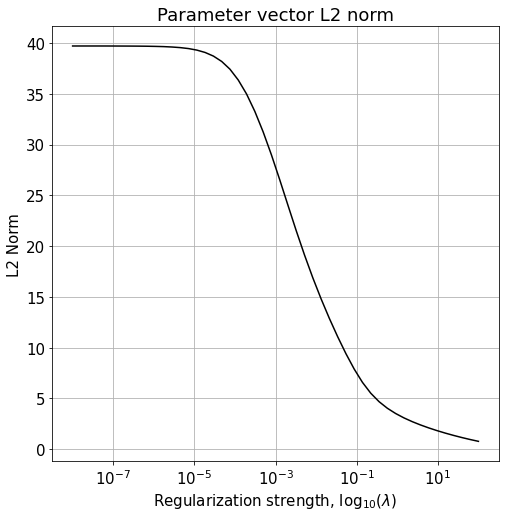

Ran Exercise 9.1.1


In [9]:
# exercise 8.1.2

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from toolbox_02450 import rocplot, confmatplot

font_size = 15
plt.rcParams.update({'font.size': font_size})

# Load Matlab data file and extract variables of interest
mat_data = loadmat('02450_toolbox/Data/wine2.mat')
X = mat_data['X']
y = mat_data['y'].squeeze()
attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
classNames = [name[0][0] for name in mat_data['classNames']]
N, M = X.shape
C = len(classNames)

# Create crossvalidation partition for evaluation
# using stratification and 95 pct. split between training and test 
K = 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.95, stratify=y)
# Try to change the test_size to e.g. 50 % and 99 % - how does that change the 
# effect of regularization? How does differetn runs of  test_size=.99 compare 
# to eachother?

# Standardize the training and set set based on training set mean and std
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)

X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

# Fit regularized logistic regression model to training data to predict 
# the type of wine
lambda_interval = np.logspace(-8, 2, 50)
train_error_rate = np.zeros(len(lambda_interval))
test_error_rate = np.zeros(len(lambda_interval))
coefficient_norm = np.zeros(len(lambda_interval))
for k in range(0, len(lambda_interval)):
    mdl = LogisticRegression(penalty='l2', C=1/lambda_interval[k] )
    
    mdl.fit(X_train, y_train)

    y_train_est = mdl.predict(X_train).T
    y_test_est = mdl.predict(X_test).T
    
    train_error_rate[k] = np.sum(y_train_est != y_train) / len(y_train)
    test_error_rate[k] = np.sum(y_test_est != y_test) / len(y_test)

    w_est = mdl.coef_[0] 
    coefficient_norm[k] = np.sqrt(np.sum(w_est**2))

min_error = np.min(test_error_rate)
opt_lambda_idx = np.argmin(test_error_rate)
opt_lambda = lambda_interval[opt_lambda_idx]

plt.figure(figsize=(8,8))
#plt.plot(np.log10(lambda_interval), train_error_rate*100)
#plt.plot(np.log10(lambda_interval), test_error_rate*100)
#plt.plot(np.log10(opt_lambda), min_error*100, 'o')
plt.semilogx(lambda_interval, train_error_rate*100)
plt.semilogx(lambda_interval, test_error_rate*100)
plt.semilogx(opt_lambda, min_error*100, 'o')
plt.text(1e-8, 3, "Minimum test error: " + str(np.round(min_error*100,2)) + ' % at 1e' + str(np.round(np.log10(opt_lambda),2)))
plt.xlabel('Regularization strength, $\log_{10}(\lambda)$')
plt.ylabel('Error rate (%)')
plt.title('Classification error')
plt.legend(['Training error','Test error','Test minimum'],loc='upper right')
plt.ylim([0, 4])
plt.grid()
plt.show()    

plt.figure(figsize=(8,8))
plt.semilogx(lambda_interval, coefficient_norm,'k')
plt.ylabel('L2 Norm')
plt.xlabel('Regularization strength, $\log_{10}(\lambda)$')
plt.title('Parameter vector L2 norm')
plt.grid()
plt.show()    

print('Ran Exercise 8.1.2')

Training model of type:
Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Sigmoid()
)


Crossvalidation fold: 1/4

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.6483443	0.00028289168
		2000	0.5445618	8.678975e-05
		3000	0.5158258	3.339338e-05
		4000	0.5036485	1.7041493e-05
		5000	0.49713883	1.0011164e-05
		6000	0.49320903	6.4050446e-06
		7000	0.4906612	4.2517195e-06
		8000	0.48892832	3.0477097e-06
		9000	0.48770553	2.0776406e-06
		10000	0.48681462	1.5916925e-06
		Final loss:
		10000	0.48681462	1.5916925e-06

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.6680346	7.851086e-05
		2000	0.59132737	0.00012819868
		3000	0.539321	6.1002178e-05
		4000	0.51656586	2.9999548e-05
		5000	0.5050216	1.675912e-05
		6000	0.4983527	1.04053815e-05
		7000	0.49416947	6.754439e-06
		8000	0.49140096	4.5485544e-06
		9000	0.48949662	3.1050547e-06
		10000	0.48814514	2.0757695e-06
		Final loss:
		10000	0.48814514	2

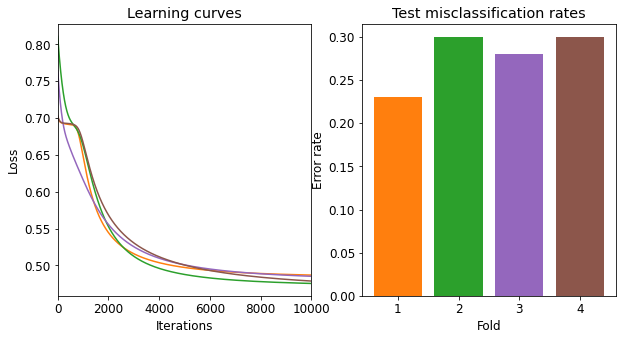

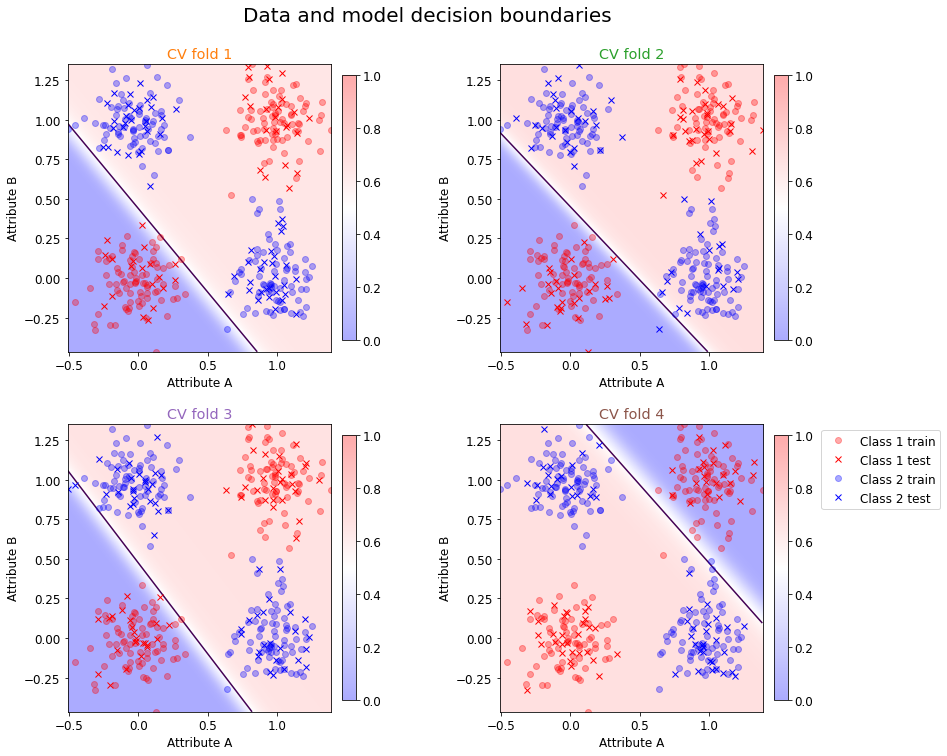

Diagram of best neural net in last fold:


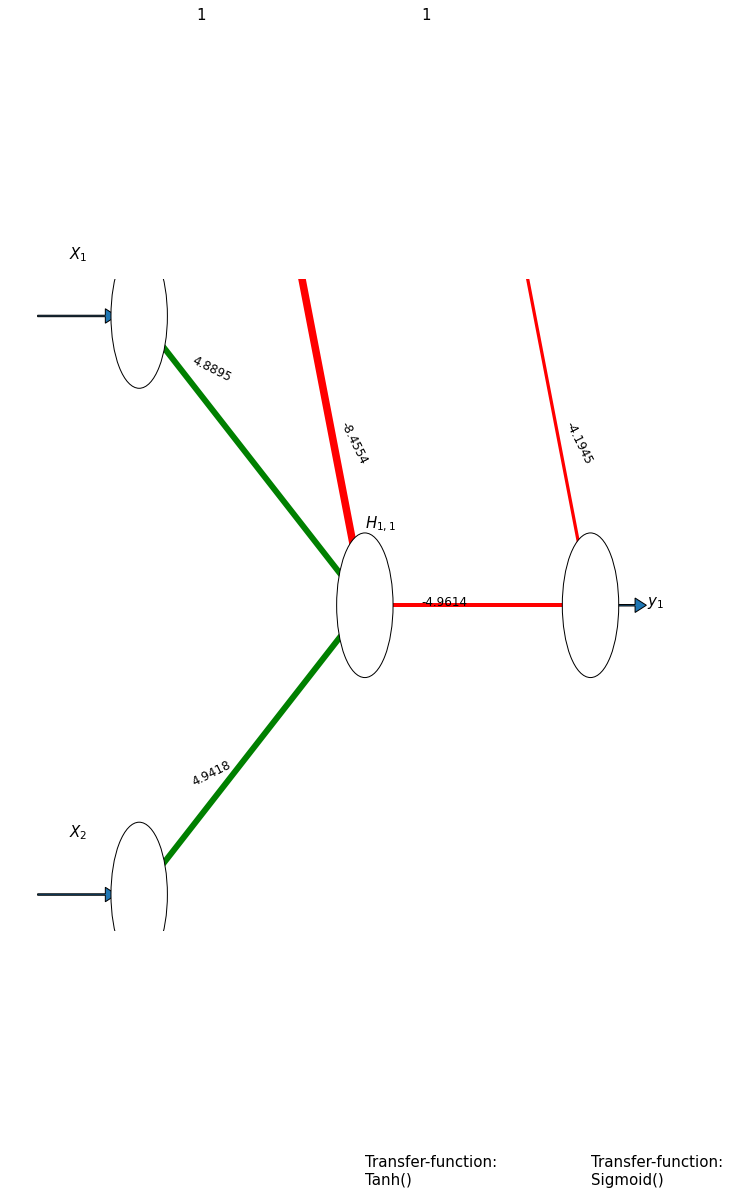


Generalization error/average error rate: 27.75%
Ran exercise 8.2.2.


In [10]:
# exercise 8.2.2
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn import model_selection
from toolbox_02450 import train_neural_net, draw_neural_net, visualize_decision_boundary
import torch
plt.rcParams.update({'font.size': 12})

# read XOR DATA from matlab datafile
mat_data = loadmat('02450_toolbox/Data/xor.mat')
X = mat_data['X']
y = mat_data['y']

attributeNames = [name[0] for name in mat_data['attributeNames'].squeeze()]
classNames = [name[0] for name in mat_data['classNames'].squeeze()]
N, M = X.shape
C = len(classNames)

# K-fold CrossValidation (4 folds here to speed up this example)
K = 4
CV = model_selection.KFold(K,shuffle=True)

# Setup figure for display of the decision boundary for the several crossvalidation folds.
decision_boundaries = plt.figure(1, figsize=(10,10))
# Determine a size of a plot grid that fits visualizations for the chosen number
# of cross-validation splits, if K=4, this is simply a 2-by-2 grid.
subplot_size_1 = int(np.floor(np.sqrt(K))) 
subplot_size_2 = int(np.ceil(K/subplot_size_1))
# Set overall title for all of the subplots
plt.suptitle('Data and model decision boundaries', fontsize=20)
# Change spacing of subplots
plt.subplots_adjust(left=0, bottom=0, right=1, top=.9, wspace=.5, hspace=0.25)

# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10,5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']

# Define the model structure
n_hidden_units = 1 # number of hidden units in the signle hidden layer
# The lambda-syntax defines an anonymous function, which is used here to 
# make it easy to make new networks within each cross validation fold
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    torch.nn.Tanh(),                            #torch.nn.ReLU(),
                    torch.nn.Linear(n_hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
# Since we're training a neural network for binary classification, we use a 
# binary cross entropy loss (see the help(train_neural_net) for more on
# the loss_fn input to the function)
loss_fn = torch.nn.BCELoss()
# Train for a maximum of 10000 steps, or until convergence (see help for the 
# function train_neural_net() for more on the tolerance/convergence))
max_iter = 10000
print('Training model of type:\n{}\n'.format(str(model())))

# Do cross-validation:
errors = [] # make a list for storing generalizaition error in each loop
# Loop over each cross-validation split. The CV.split-method returns the 
# indices to be used for training and testing in each split, and calling 
# the enumerate-method with this simply returns this indices along with 
# a counter k:
for k, (train_index, test_index) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, 
    # and convert them to PyTorch tensors
    X_train = torch.Tensor(X[train_index,:] )
    y_train = torch.Tensor(y[train_index] )
    X_test = torch.Tensor(X[test_index,:] )
    y_test = torch.Tensor(y[test_index] )
    
    # Go to the file 'toolbox_02450.py' in the Tools sub-folder of the toolbox
    # and see how the network is trained (search for 'def train_neural_net',
    # which is the place the function below is defined)
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=3,
                                                       max_iter=max_iter)
    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_sigmoid = net(X_test) # activation of final note, i.e. prediction of network
    y_test_est = (y_sigmoid > .5).type(dtype=torch.uint8) # threshold output of sigmoidal function
    y_test = y_test.type(dtype=torch.uint8)
    # Determine errors and error rate
    e = (y_test_est != y_test)
    error_rate = (sum(e).type(torch.float)/len(y_test)).data.numpy()
    errors.append(error_rate) # store error rate for current CV fold 
    
    # Make a subplot for current cross validation fold that displays the 
    # decision boundary over the original data, "background color" corresponds
    # to the output of the sigmoidal transfer function (i.e. before threshold),
    # white areas are areas of uncertainty, and a deaper red/blue means 
    # that the network "is more sure" of a given class.
    plt.figure(decision_boundaries.number)
    plt.subplot(subplot_size_1,subplot_size_2,k+1)
    plt.title('CV fold {0}'.format(k+1),color=color_list[k])
    predict = lambda x: net(torch.tensor(x, dtype=torch.float)).data.numpy()
    visualize_decision_boundary(predict, X, y, # provide data, along with function for prediction
                                attributeNames, classNames, # provide information on attribute and class names
                                train=train_index, test=test_index, # provide information on partioning
                                show_legend=k==(K-1)) # only display legend for last plot
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')
    
# Display the error rate across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors)), color=color_list)
summaries_axes[1].set_xlabel('Fold')
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('Error rate')
summaries_axes[1].set_title('Test misclassification rates')

# Show the plots
# plt.show(decision_boundaries.number) # try these lines if the following code fails (depends on package versions)
# plt.show(summaries.number)
plt.show()

# Display a diagram of the best network in last fold
print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,3]]
draw_neural_net(weights, biases, tf)

# Print the average classification error rate
print('\nGeneralization error/average error rate: {0}%'.format(round(100*np.mean(errors),4)))

print('Ran exercise 8.2.2.')

Training model of type:

Sequential(
  (0): Linear(in_features=11, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
  (3): Sigmoid()
)


Crossvalidation fold: 1/3

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.13467273	0.0012749094
		2000	0.061113738	0.0005362529
		3000	0.037562344	0.00036513255
		4000	0.029610567	0.00016119887
		5000	0.026037784	0.00012581641
		6000	0.023080556	9.183035e-05
		7000	0.021789122	3.65008e-05
		8000	0.021157196	2.9756085e-05
		9000	0.020608138	2.3137758e-05
		10000	0.02019101	1.9556874e-05
		Final loss:
		10000	0.02019101	1.9556874e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.11408409	0.0011789815
		2000	0.050739873	0.00060959643
		3000	0.03344781	0.00026667488
		4000	0.02742439	0.00014532616
		5000	0.024512807	8.942824e-05
		6000	0.022136312	8.270703e-05
		7000	0.02099787	3.4594294e-05
		8000	0.020485891	1.8548013e-05
		9000	0.020156616	1.5709218e-05
		10000	0.019868633	1.4811969e-05
		Final loss

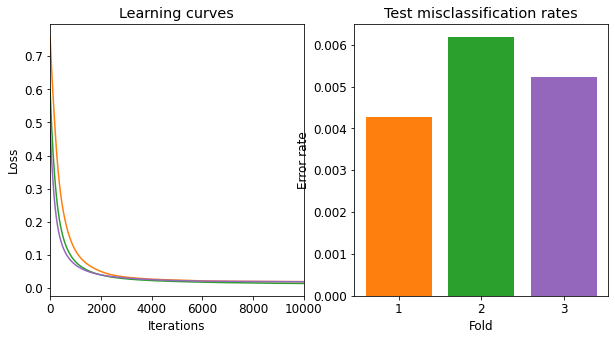

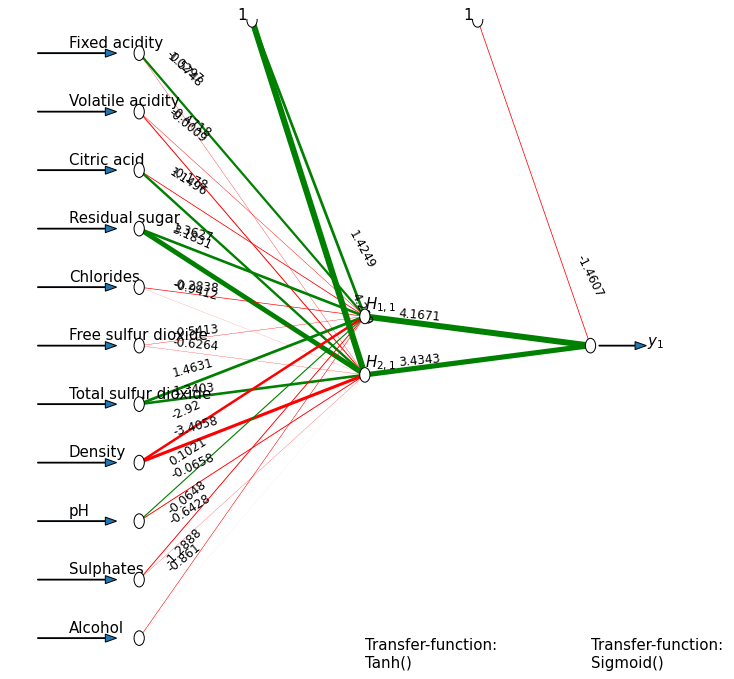


Generalization error/average error rate: 0.5235%
Ran Exercise 8.2.5


In [11]:
# exercise 8.2.5
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import torch
from sklearn import model_selection
from toolbox_02450 import train_neural_net, draw_neural_net
from scipy import stats

# Load Matlab data file and extract variables of interest
mat_data = loadmat('02450_toolbox/Data/wine2.mat')
attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
X = mat_data['X']
y = mat_data['y']

#Downsample: X = X[1:20,:] y = y[1:20,:]
N, M = X.shape
C = 2

# Normalize data
X = stats.zscore(X)

# Parameters for neural network classifier
n_hidden_units = 2     # number of hidden units
n_replicates = 2        # number of networks trained in each k-fold
max_iter = 10000         # stop criterion 2 (max epochs in training)

# K-fold crossvalidation
K = 3                   # only five folds to speed up this example
CV = model_selection.KFold(K, shuffle=True)
# Make figure for holding summaries (errors and learning curves)
summaries, summaries_axes = plt.subplots(1,2, figsize=(10,5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']

# Define the model, see also Exercise 8.2.2-script for more information.
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    torch.nn.Tanh(),   # 1st transfer function,
                    torch.nn.Linear(n_hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
loss_fn = torch.nn.BCELoss()

print('Training model of type:\n\n{}\n'.format(str(model())))
errors = [] # make a list for storing generalizaition error in each loop
for k, (train_index, test_index) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.Tensor(X[train_index,:])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index,:])
    y_test = torch.Tensor(y[test_index])
    
    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=n_replicates,
                                                       max_iter=max_iter)
    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_sigmoid = net(X_test)
    y_test_est = (y_sigmoid>.5).type(dtype=torch.uint8)

    # Determine errors and errors
    y_test = y_test.type(dtype=torch.uint8)

    e = y_test_est != y_test
    error_rate = (sum(e).type(torch.float)/len(y_test)).data.numpy()
    errors.append(error_rate) # store error rate for current CV fold 
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')
    
# Display the error rate across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors)), color=color_list)
summaries_axes[1].set_xlabel('Fold')
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('Error rate')
summaries_axes[1].set_title('Test misclassification rates')

print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,3]]
draw_neural_net(weights, biases, tf, attribute_names=attributeNames)

# Print the average classification error rate
print('\nGeneralization error/average error rate: {0}%'.format(round(100*np.mean(errors),4)))

print('Ran Exercise 8.2.5')

Training model of type:

Sequential(
  (0): Linear(in_features=10, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
)


Crossvalidation fold: 1/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	64.47663	0.0006705884
		2000	18.923544	0.0013362307
		3000	5.136346	0.0013100525
		4000	1.5720326	0.0009521405
		5000	0.83380777	0.0003957266
		6000	0.6764866	0.00012465888
		7000	0.58341396	0.00018866366
		8000	0.46091753	0.0002741423
		9000	0.35904005	0.00020846652
		10000	0.3042242	0.000128901
		Final loss:
		10000	0.3042242	0.000128901

	Best loss: 0.3042241930961609


Crossvalidation fold: 2/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	35.55297	0.0011378671
		2000	10.893771	0.0012558897
		3000	2.9627671	0.0012704787
		4000	1.0750253	0.0006819501
		5000	0.7099612	0.00017946314
		6000	0.6251229	0.00012803689
		7000	0.5251511	0.0002286502
		8000	0.41020676	0.00023599049
		9000	0.33770767	0.00015194148
		10000	0.2996643	9.287988e-05
		Final l

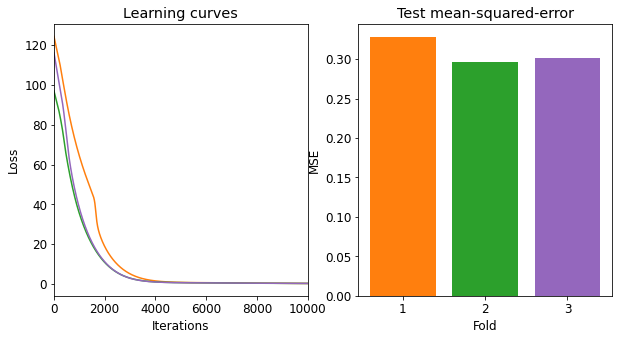

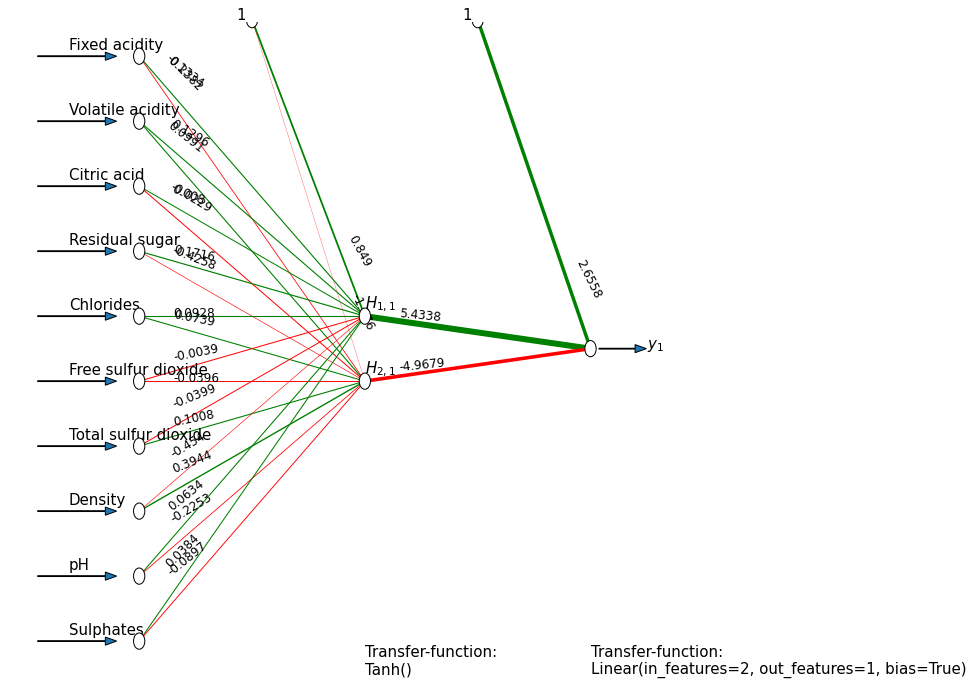


Estimated generalization error, RMSE: 0.5555999875068665


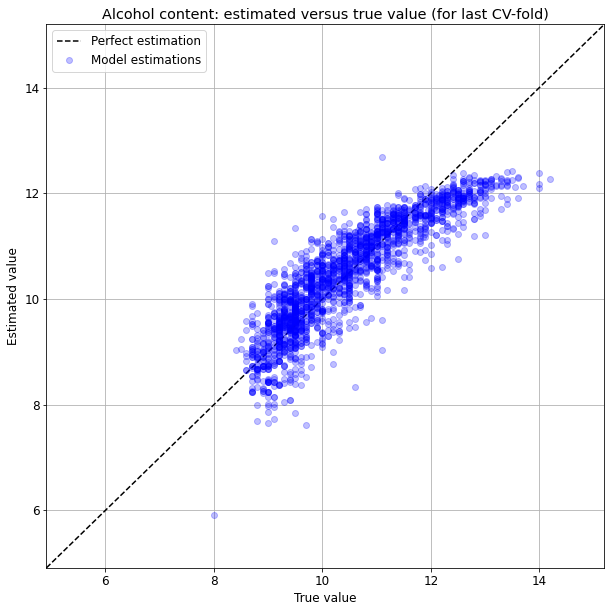

Ran Exercise 8.2.5


In [12]:
# exercise 8.2.6
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import torch
from sklearn import model_selection
from toolbox_02450 import train_neural_net, draw_neural_net
from scipy import stats

# Load Matlab data file and extract variables of interest
mat_data = loadmat('02450_toolbox/Data/wine2.mat')
attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
X = mat_data['X']
y = X[:,[10]]             # alcohol contents (target)
X = X[:,:10]           # the rest of features
N, M = X.shape
C = 2

# Normalize data
X = stats.zscore(X)
                
## Normalize and compute PCA (change to True to experiment with PCA preprocessing)
do_pca_preprocessing = False
if do_pca_preprocessing:
    Y = stats.zscore(X,0)
    U,S,V = np.linalg.svd(Y,full_matrices=False)
    V = V.T
    #Components to be included as features
    k_pca = 3
    X = X @ V[:,:k_pca]
    N, M = X.shape


# Parameters for neural network classifier
n_hidden_units = 2      # number of hidden units
n_replicates = 1        # number of networks trained in each k-fold
max_iter = 10000

# K-fold crossvalidation
K = 3                   # only three folds to speed up this example
CV = model_selection.KFold(K, shuffle=True)

# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1,2, figsize=(10,5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']
# Define the model
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to n_hidden_units
                    torch.nn.Tanh(),   # 1st transfer function,
                    torch.nn.Linear(n_hidden_units, 1), # n_hidden_units to 1 output neuron
                    # no final tranfer function, i.e. "linear output"
                    )
loss_fn = torch.nn.MSELoss() # notice how this is now a mean-squared-error loss

print('Training model of type:\n\n{}\n'.format(str(model())))
errors = [] # make a list for storing generalizaition error in each loop
for (k, (train_index, test_index)) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.Tensor(X[train_index,:])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index,:])
    y_test = torch.Tensor(y[test_index])
    
    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=n_replicates,
                                                       max_iter=max_iter)
    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_test_est = net(X_test)
    
    # Determine errors and errors
    se = (y_test_est.float()-y_test.float())**2 # squared error
    mse = (sum(se).type(torch.float)/len(y_test)).data.numpy() #mean
    errors.append(mse) # store error rate for current CV fold 
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')

# Display the MSE across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors)), color=color_list)
summaries_axes[1].set_xlabel('Fold')
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('MSE')
summaries_axes[1].set_title('Test mean-squared-error')
    
print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,2]]
draw_neural_net(weights, biases, tf, attribute_names=attributeNames)

# Print the average classification error rate
print('\nEstimated generalization error, RMSE: {0}'.format(round(np.sqrt(np.mean(errors)), 4)))

# When dealing with regression outputs, a simple way of looking at the quality
# of predictions visually is by plotting the estimated value as a function of 
# the true/known value - these values should all be along a straight line "y=x", 
# and if the points are above the line, the model overestimates, whereas if the
# points are below the y=x line, then the model underestimates the value
plt.figure(figsize=(10,10))
y_est = y_test_est.data.numpy(); y_true = y_test.data.numpy()
axis_range = [np.min([y_est, y_true])-1,np.max([y_est, y_true])+1]
plt.plot(axis_range,axis_range,'k--')
plt.plot(y_true, y_est,'ob',alpha=.25)
plt.legend(['Perfect estimation','Model estimations'])
plt.title('Alcohol content: estimated versus true value (for last CV-fold)')
plt.ylim(axis_range); plt.xlim(axis_range)
plt.xlabel('True value')
plt.ylabel('Estimated value')
plt.grid()

plt.show()

print('Ran Exercise 8.2.5')


	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.8940439	0.0005110867
		2000	0.75511503	1.5707723e-05
		3000	0.74915755	4.2167803e-06
		4000	0.7466158	2.4748194e-06
		5000	0.7452258	1.2797103e-06
		Final loss:
		5216	0.745026	9.600404e-07

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.78257155	0.00011042721
		2000	0.7544253	1.1534844e-05
		3000	0.7493528	4.0566e-06
		4000	0.7470726	2.4733065e-06
		5000	0.74562776	1.5987749e-06
		Final loss:
		5691	0.7449154	9.601829e-07

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	0.8358758	0.0002572844
		2000	0.75357354	1.7796281e-05
		3000	0.7474562	3.6681797e-06
		4000	0.74564123	1.4388717e-06
		Final loss:
		4562	0.7450801	9.599706e-07
Number of miss-classifications for ANN:
	 0 out of 40


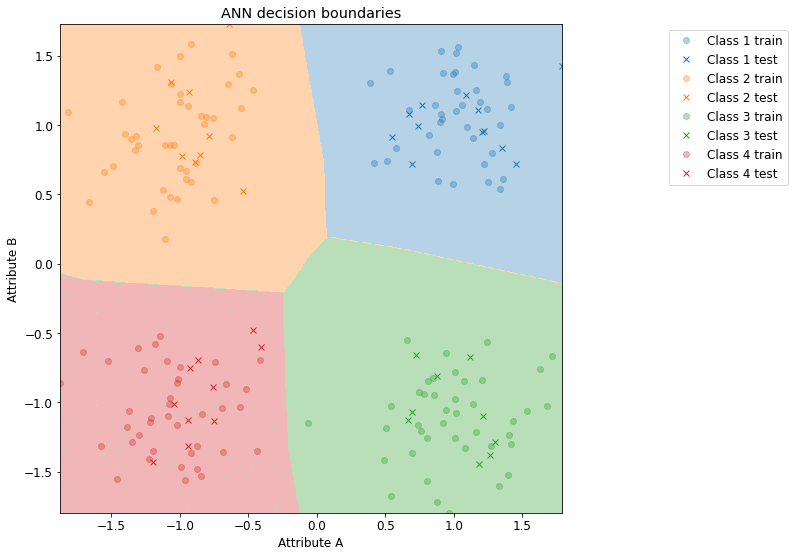

Ran Exercise 8.3.1


In [13]:
# exercise 8.3.1 Fit neural network classifiers using softmax output weighting
from matplotlib.pyplot import figure, show, title
from scipy.io import loadmat
from toolbox_02450 import dbplotf, train_neural_net, visualize_decision_boundary
import numpy as np
import torch
# Load Matlab data file and extract variables of interest
mat_data = loadmat('02450_toolbox/Data/synth1.mat')
X = mat_data['X']
X = X - np.ones((X.shape[0],1)) * np.mean(X,0)
X_train = mat_data['X_train']
X_test = mat_data['X_test']
y = mat_data['y'].squeeze()
y_train = mat_data['y_train'].squeeze()
y_test = mat_data['y_test'].squeeze()

attributeNames = [name[0] for name in mat_data['attributeNames'].squeeze()]
classNames = [name[0][0] for name in mat_data['classNames']]

N, M = X.shape
C = len(classNames)
#%% Model fitting and prediction

# Define the model structure
n_hidden_units = 5 # number of hidden units in the signle hidden layer
model = lambda: torch.nn.Sequential(
                            torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                            torch.nn.ReLU(), # 1st transfer function
                            # Output layer:
                            # H hidden units to C classes
                            # the nodes and their activation before the transfer 
                            # function is often referred to as logits/logit output
                            torch.nn.Linear(n_hidden_units, C), # C logits
                            # To obtain normalised "probabilities" of each class
                            # we use the softmax-funtion along the "class" dimension
                            # (i.e. not the dimension describing observations)
                            torch.nn.Softmax(dim=1) # final tranfer function, normalisation of logit output
                            )
# Since we're training a multiclass problem, we cannot use binary cross entropy,
# but instead use the general cross entropy loss:
loss_fn = torch.nn.CrossEntropyLoss()
# Train the network:
net, _, _ = train_neural_net(model, loss_fn,
                             X=torch.tensor(X_train, dtype=torch.float),
                             y=torch.tensor(y_train, dtype=torch.long),
                             n_replicates=3,
                             max_iter=10000)
# Determine probability of each class using trained network
softmax_logits = net(torch.tensor(X_test, dtype=torch.float))
# Get the estimated class as the class with highest probability (argmax on softmax_logits)
y_test_est = (torch.max(softmax_logits, dim=1)[1]).data.numpy() 
# Determine errors
e = (y_test_est != y_test)
print('Number of miss-classifications for ANN:\n\t {0} out of {1}'.format(sum(e),len(e)))

predict = lambda x:  (torch.max(net(torch.tensor(x, dtype=torch.float)), dim=1)[1]).data.numpy() 
figure(1,figsize=(9,9))
visualize_decision_boundary(predict, [X_train, X_test], [y_train, y_test], attributeNames, classNames)
title('ANN decision boundaries')

show()

print('Ran Exercise 8.3.1')

Number of miss-classifications for Multinormal regression:
	 0 out of 40


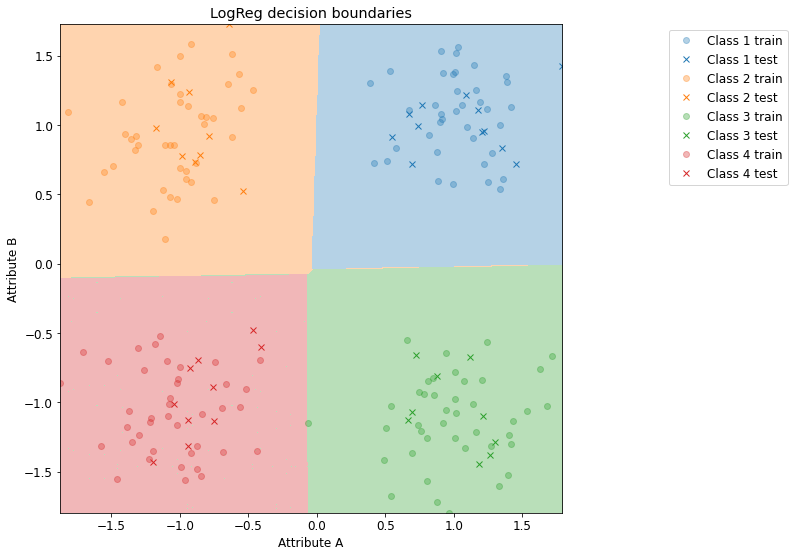

Ran Exercise 8.3.2


In [14]:
# exercise 8.3.2 Fit multinomial regression
from matplotlib.pyplot import figure, show, title
from scipy.io import loadmat
from toolbox_02450 import dbplotf, train_neural_net, visualize_decision_boundary
import numpy as np
import sklearn.linear_model as lm

# Load Matlab data file and extract variables of interest
mat_data = loadmat('02450_toolbox/Data/synth1.mat')
X = mat_data['X']
X = X - np.ones((X.shape[0],1)) * np.mean(X,0)
X_train = mat_data['X_train']
X_test = mat_data['X_test']
y = mat_data['y'].squeeze()
y_train = mat_data['y_train'].squeeze()
y_test = mat_data['y_test'].squeeze()

attributeNames = [name[0] for name in mat_data['attributeNames'].squeeze()]
classNames = [name[0][0] for name in mat_data['classNames']]

N, M = X.shape
C = len(classNames)
#%% Model fitting and prediction

# Multinomial logistic regression
logreg = lm.LogisticRegression(solver='lbfgs', multi_class='multinomial', tol=1e-4, random_state=1)
logreg.fit(X_train,y_train)

# To display coefficients use print(logreg.coef_). For a 4 class problem with a 
# feature space, these weights will have shape (4, 2).

# Number of miss-classifications
print('Number of miss-classifications for Multinormal regression:\n\t {0} out of {1}'.format(np.sum(logreg.predict(X_test)!=y_test),len(y_test)))

predict = lambda x: np.argmax(logreg.predict_proba(x),1)
figure(2,figsize=(9,9))
visualize_decision_boundary(predict, [X_train, X_test], [y_train, y_test], attributeNames, classNames)
title('LogReg decision boundaries')

show()

print('Ran Exercise 8.3.2')

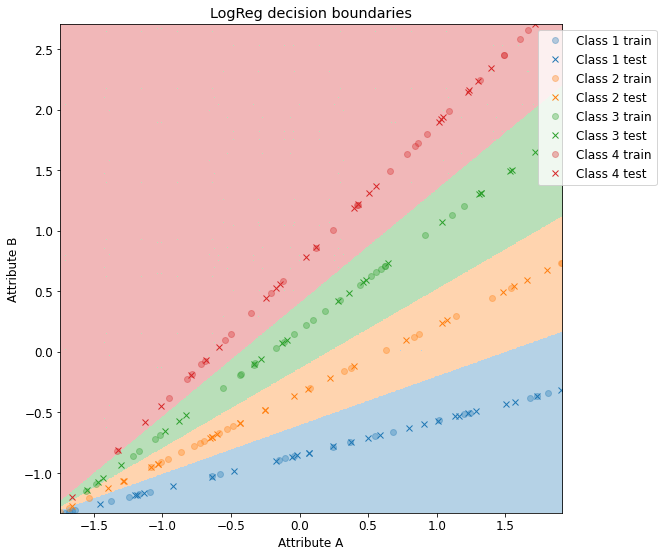

Error rate: 
	 1.0 % out of 100
Ran Exercise 8.3.2


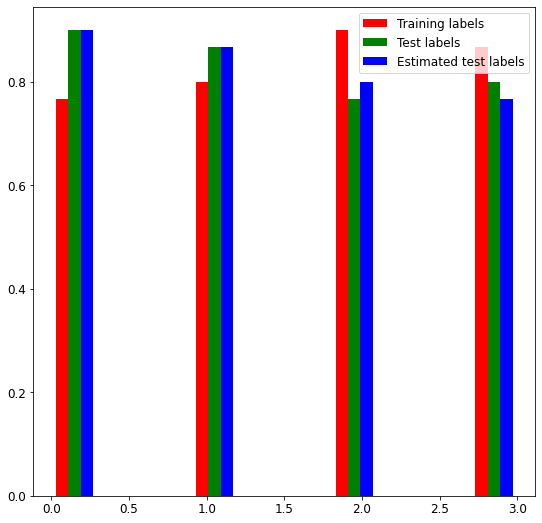

In [15]:
# exercise 8.3.3 Fit regularized multinomial regression
import matplotlib.pyplot as plt
from scipy.io import loadmat
from toolbox_02450 import dbplotf, train_neural_net, visualize_decision_boundary
import numpy as np
import sklearn.linear_model as lm

# Load Matlab data file and extract variables of interest
mat_data = loadmat('02450_toolbox/Data/synth2.mat')
X = mat_data['X']
X_train = mat_data['X_train']
X_test = mat_data['X_test']
y = mat_data['y'].squeeze()
y_train = mat_data['y_train'].squeeze()
y_test = mat_data['y_test'].squeeze()

attributeNames = [name[0] for name in mat_data['attributeNames'].squeeze()]
classNames = [name[0][0] for name in mat_data['classNames']]

N, M = X.shape
C = len(classNames)

#%% Model fitting and prediction
# Standardize data based on training set
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

# Fit multinomial logistic regression model
regularization_strength = 1e-3
#Try a high strength, e.g. 1e5, especially for synth2, synth3 and synth4
mdl = lm.LogisticRegression(solver='lbfgs', multi_class='multinomial', 
                               tol=1e-4, random_state=1, 
                               penalty='l2', C=1/regularization_strength)
mdl.fit(X_train,y_train)
y_test_est = mdl.predict(X_test)

test_error_rate = np.sum(y_test_est!=y_test) / len(y_test)

predict = lambda x: np.argmax(mdl.predict_proba(x),1)
plt.figure(2,figsize=(9,9))
visualize_decision_boundary(predict, [X_train, X_test], [y_train, y_test], attributeNames, classNames)
plt.title('LogReg decision boundaries')
plt.show()


# Number of miss-classifications
print('Error rate: \n\t {0} % out of {1}'.format(test_error_rate*100,len(y_test)))
# %%

plt.figure(2, figsize=(9,9))
plt.hist([y_train, y_test, y_test_est], color=['red','green','blue'], density=True)
plt.legend(['Training labels','Test labels','Estimated test labels'])


print('Ran Exercise 8.3.2')